In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import itertools
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from plotly_resampler.aggregation import LTTB, EveryNthPoint, MinMaxAggregator
from tqdm.auto import tqdm

sys.path.append("..")
import plotly.express as px
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler

from agg_utils.aggregators import M4Aggregator
from agg_utils.path_conf import dataset_dir, loc_data_dir, figure_root_dir
from agg_utils.conf import highlight_color


In [3]:
# fmt: off
# Get the data that will be used for benchmarking
btc_series = pd.read_parquet(dataset_dir / "btc_high.parquet").set_index('date')['high']
ball_speed_series = pd.read_parquet(dataset_dir / "ball_speed.parquet").set_index("ts")["v"]
power_series = pd.read_parquet( dataset_dir / "electrical_power.parquet").set_index("ts")["mf03"]
cinecg = pd.read_parquet(dataset_dir / "cinecg.parquet")['ECG']
hf_sine = pd.read_parquet(dataset_dir / "hf_sine.parquet")['sine']
hf_noise = pd.read_parquet(dataset_dir / "hf_noise.parquet")['noise']

data_tuple = [
    # ("sine", hf_sine),
    ("noise", hf_noise),
    ("cinecg", cinecg),
    ("ball", ball_speed_series.iloc[50_000:]),
    ("power", power_series),
    ("btc", btc_series),
]


## Figure templates

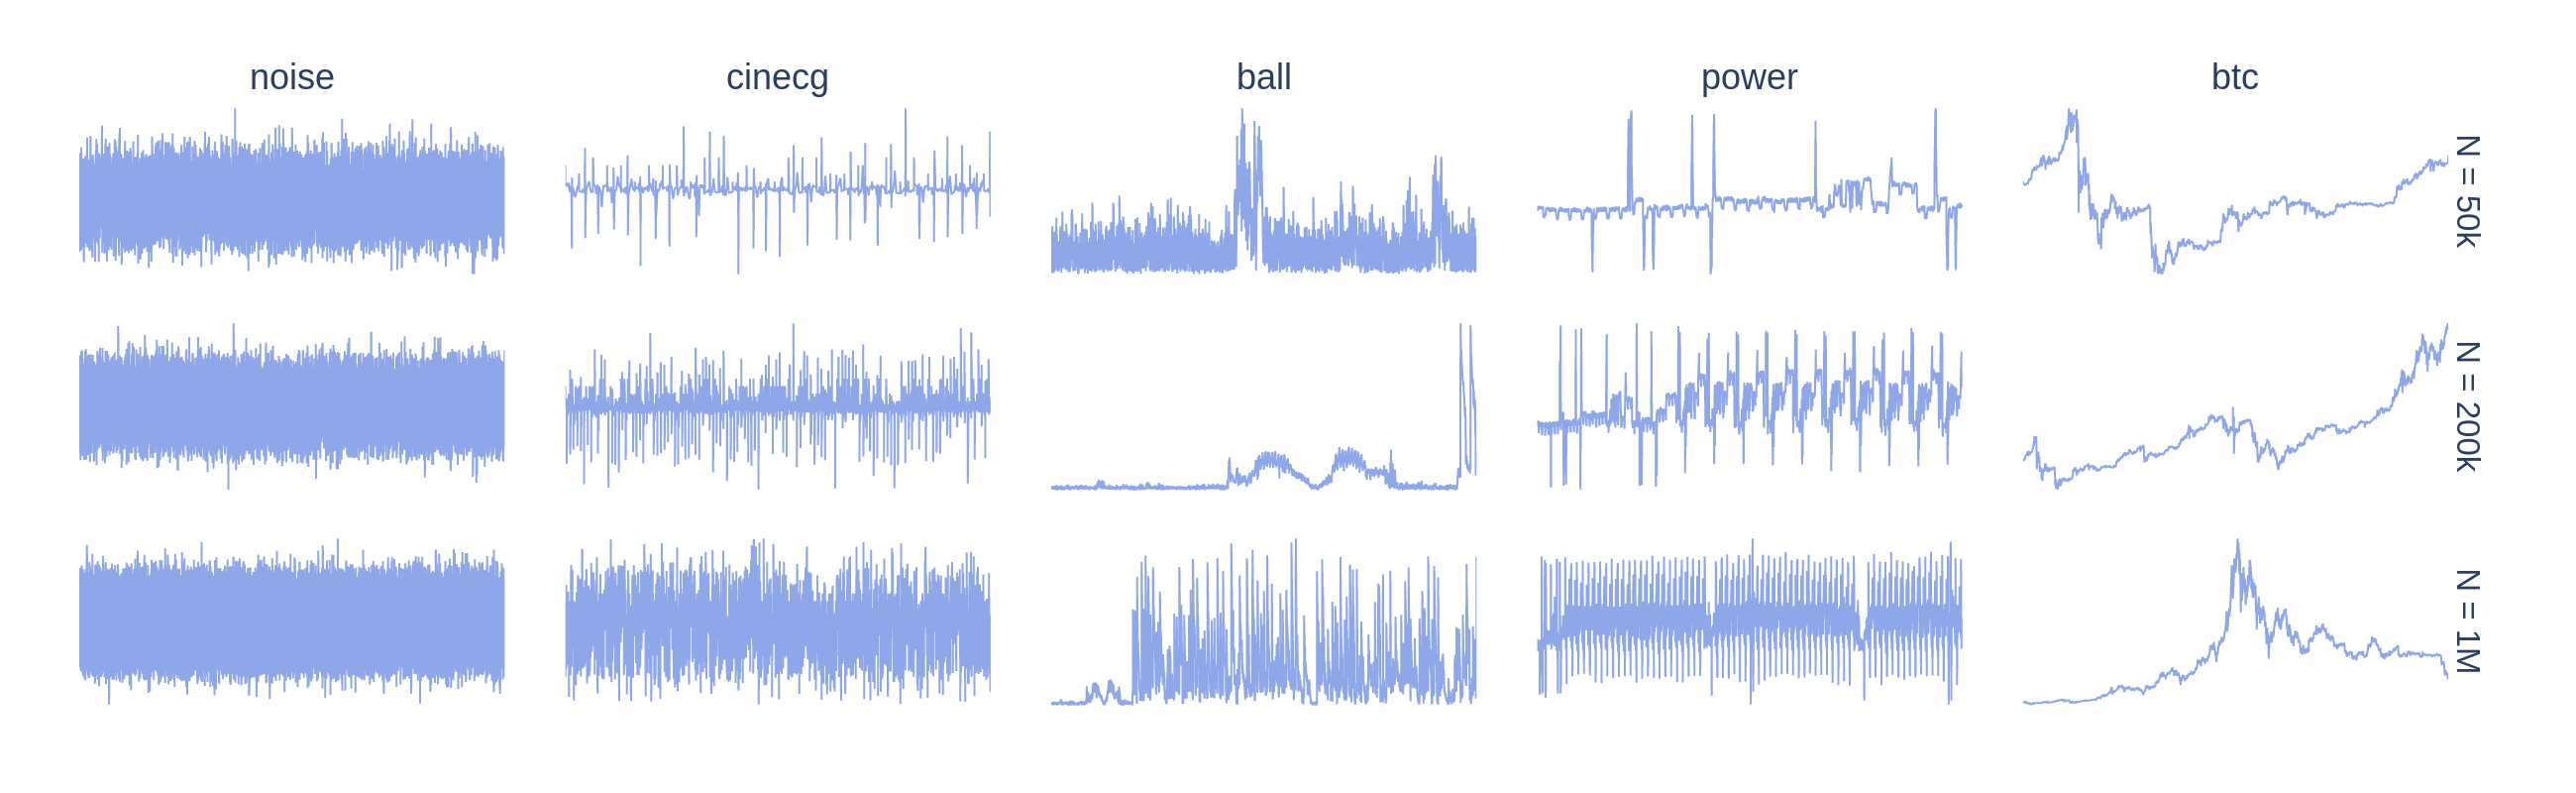

In [10]:
# n_s = [50_000, 200_000, 500_000, 1_000_000]  # [:2]
n_s = [50_000, 200_000, 1_000_000]  # [:2]

fig = FigureResampler(
    make_subplots(
        **dict(rows=len(n_s), cols=len(data_tuple)),
        # subplot_titles=[f"{name}" + f"  -  N = {n:,}" for n in n_s for name, _ in data_tuple],
        vertical_spacing=0.05,
        horizontal_spacing=0.025,
        row_titles=[f"N = {n}" for n in ['50k', '200k', '1M']],
        column_titles=[name for name, _ in data_tuple],
    ),
    default_n_shown_samples=6000,
)


font_size = 33 
for row_idx, n in enumerate(n_s, 1):
    for i, (name, hf_series) in enumerate(data_tuple, 1):
        fig.add_trace(
            {
                "line_width": 2,
                "showlegend": False,
                'line_color': highlight_color,
            },
            hf_y=hf_series.iloc[:n],
            hf_x=hf_series.iloc[:n].index,
            row=row_idx,
            col=i,
        )


# for row_idx, n, in enumerate(['N = 50K', 'N = 200K', 'N = 1M'], 1):
fig.update_annotations(font_size=font_size + 3)
for annotation in fig.layout.annotations:
    if 'N = ' in annotation.text:
        annotation.update(font_size=font_size)

# do not show the axis labels
fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False)


fig.update_layout(template='plotly_white', height=800).show(
    renderer="png", width=2600, height=800
)
del hf_series, row_idx, n
# fig.write_html('template_grid.html')

# Serializing aggregations and corresponding references

In [4]:
agg_data_dir = Path(figure_root_dir / "data")
agg_data_dir.mkdir(exist_ok=True)


In [ ]:
# we create aggregation 
n_out_grid = np.arange(200, 4001, 20)
n_grid = [50_000, 200_000, 1_000_000] 
data_grid = [
    ("sine", hf_sine),
    ("noise", hf_noise),
    ("cinecg", cinecg),
    ("ball", ball_speed_series.iloc[50_000:]),
    ("power", power_series),
    ("btc", btc_series),
]
aggregator_grid = [LTTB, M4Aggregator, MinMaxAggregator, EveryNthPoint]

df_list = []
for (s_name, data), n in tqdm(list(itertools.product(data_grid, n_grid))):
    # Save the reference figure and the x_lim and y_lim
    reference = data.iloc[:n]
    save_name = agg_data_dir / f"{s_name}_reference_{n}.parquet"
    reference.reset_index(drop=False).to_parquet(save_name, engine="fastparquet")
    df_list.append([s_name, "reference", n, None, save_name])

    for n_out, aggregator_class in tqdm(
        list(itertools.product(n_out_grid, aggregator_grid))
    ):
        # fmt: off
        s_agg = aggregator_class()._aggregate(reference, n_out)
        save_name = save_name.parent / f"{s_name}_{aggregator_class.__name__}_{n}_{int(n_out)}.parquet"
        s_agg.reset_index(drop=False).to_parquet(save_name, engine="fastparquet")
        df_list.append([s_name, aggregator_class.__name__, n, n_out, save_name])


In [7]:
pd.DataFrame(
    df_list,
    columns=["data", "aggregator", "n", "n_out", "path"],
).to_csv(loc_data_dir / "agg_data.csv", index=False)
